#### CUDA SETTINGS

In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
from reproduce.reproduce_utils import call_cfg_key, reconstruct_from_config, eval_ose, plot_results
from omegaconf import OmegaConf

#### IMPORTANT FILE PATHS

In [9]:
concatenated_6_nadirs_filepath = '/DATASET/OCB_traces/input_test_6sat_2017.nc'
test_1_nadir_filepath = '/DATASET/OCB_traces/concat/concatenated_ref_2017.nc'

your_config = 'reproduce/config.yaml'
best_ckpt_path = '/homes/p24hasle/repos/4dvarnet-starter-glorys12/outputs/2024-06-20/15-16-55/base_forecast_glorys12_10y/checkpoints/val_mse=26.93737-epoch=018.ckpt'
your_rec_dir = 'rec_dir'

In [10]:
REC_PATHS = '/homes/p24hasle/repos/4dvarnet-starter-glorys12/'+your_rec_dir+'/reproduce/version_0/test_data_{}.nc'

#### LOADING CONFIG

In [11]:
config = OmegaConf.load(your_config)
# data override:
OmegaConf.update(config, key='paths.ose_6_sats', value=concatenated_6_nadirs_filepath)


### PREDICT WITH MODEL:

/DATASET/envs/p24hasle/miniconda/envs/4dvarnet-starter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /DATASET/envs/p24hasle/miniconda/envs/4dvarnet-start ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 333


test_regrid: None


You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: rec_dir/reproduce
Restoring states from the checkpoint path at /homes/p24hasle/repos/4dvarnet-starter-glorys12/outputs/2024-06-20/15-16-55/base_forecast_glorys12_10y/checkpoints/val_mse=26.93737-epoch=018.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
Loaded model weights from the checkpoint at /homes/p24hasle/repos/4dvarnet-starter-glorys12/outputs/2024-06-20/15-16-55/base_forecast_glorys12_10y/checkpoints/val_mse=26.93737-epoch=018.ckpt


Norm stats (0.44505587220191956, 0.38981562852859497)
Testing DataLoader 0: 100%|██████████| 80/80 [00:13<00:00,  5.89it/s]rec_dir/reproduce/version_0/test_data_0.nc
rec_dir/reproduce/version_0/test_data_1.nc
rec_dir/reproduce/version_0/test_data_2.nc
rec_dir/reproduce/version_0/test_data_3.nc
rec_dir/reproduce/version_0/test_data_4.nc
rec_dir/reproduce/version_0/test_data_5.nc
rec_dir/reproduce/version_0/test_data_6.nc
rec_dir/reproduce/version_0/test_data_7.nc
rec_dir/reproduce/version_0/test_data_8.nc
rec_dir/reproduce/version_0/test_data_9.nc
rec_dir/reproduce/version_0/test_data_10.nc
rec_dir/reproduce/version_0/test_data_11.nc
rec_dir/reproduce/version_0/test_data_12.nc
rec_dir/reproduce/version_0/test_data_13.nc
rec_dir/reproduce/version_0/test_data_14.nc
rec_dir/reproduce/version_0/test_data_15.nc
rec_dir/reproduce/version_0/test_data_16.nc
rec_dir/reproduce/version_0/test_data_17.nc
rec_dir/reproduce/version_0/test_data_18.nc
rec_dir/reproduce/version_0/test_data_19.nc
|     |

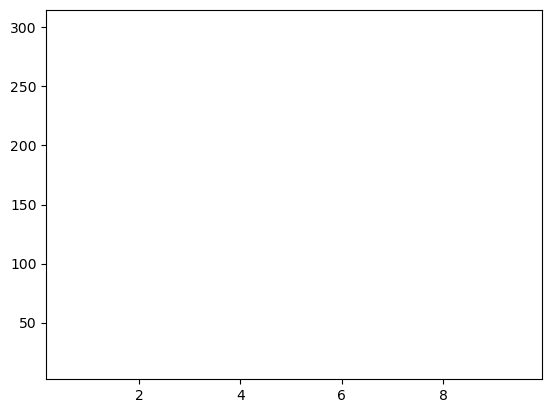

In [12]:
reconstruct_from_config(config, your_rec_dir, best_ckpt_path)

### OSE RESULTS:

In [14]:
lead_times = range(13,20)

RMSE_array = []

for lead_time in lead_times:
    a,b = eval_ose(
        path_alongtrack = test_1_nadir_filepath,
        path_rec = REC_PATHS.format(lead_time),
        time_min = '2017-01-25',
        time_max= '2017-12-05'
    )

    print('leadtime {} - RMSE: {:.4f} | PSD: {:.4f}'.format(lead_time-lead_times[0], a, b))
    RMSE_array.append(a)

leadtime 0 - RMSE: 0.8330 | PSD: 15.0000
leadtime 1 - RMSE: 0.8134 | PSD: 15.0000
leadtime 2 - RMSE: 0.7867 | PSD: 173.0000
leadtime 3 - RMSE: 0.7712 | PSD: 69.0000
leadtime 4 - RMSE: 0.7530 | PSD: 53.0000
leadtime 5 - RMSE: 0.7406 | PSD: 13.0000
leadtime 6 - RMSE: 0.7091 | PSD: 276.0000


#### PLOT RESULTS

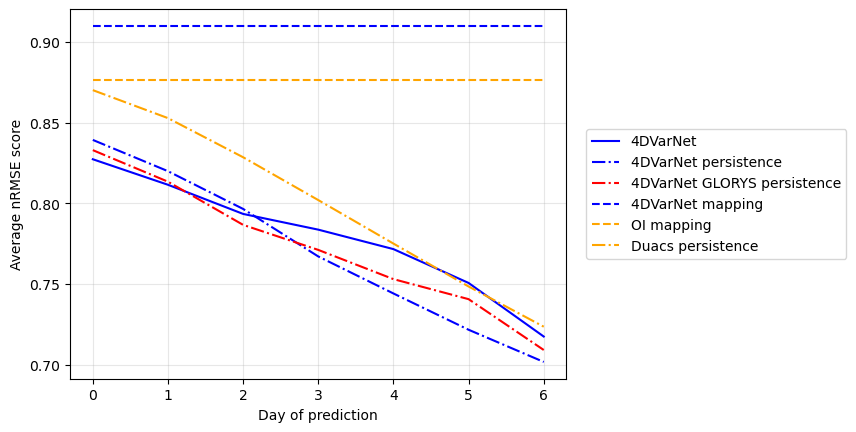

In [15]:
plot_results(RMSE_array)